In [68]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from ipywidgets import interact
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Function Definitions

In [2]:
def load_load_data():
    load_history_raw = pd.read_csv("Load_history.csv")
    
    # step 1: prep the data for unpivoting

    # init empty df to hold prepped data
    load_data_wide = pd.DataFrame()
    
    # copy over the zone_id column (it doesn't need any prepping)
    load_data_wide['zone_id'] = load_history_raw['zone_id']
    
    # convert year, month, day columns to one date column
    load_data_wide['date'] = pd.to_datetime(load_history_raw[['year', 'month', 'day']])
    
    # bring in the hour columns
    hour_columns = [f'h{i}' for i in range(1, 25)]
    for col in hour_columns:
        load_data_wide[col] = load_history_raw[col]
    
    # step 2: unpivoting
    load_data_long = load_data_wide.melt(
        id_vars = ['zone_id', 'date'], # cols to preserve
        value_vars=hour_columns,       # cols to unpivot
        var_name='hour',               # colname for new index col (hour)
        value_name='load'              # colname for new value col (load)
    )
    
    # step 3: clean up after unpivot
    
    # convert 'hour' from string (i.e. 'h1') to numeric (i.e. 1)
    load_data_long['hour'] = load_data_long['hour'].str.extract(r'(\d+)').astype(int)
    
    # create a full datetime column by augmenting 'date' with 'hour'
    load_data_long['datetime'] = load_data_long['date'] + pd.to_timedelta(load_data_long['hour'] - 1, unit='h')

    # change dtype on 'load'
    load_data_long['load'] = (
        load_data_long['load']
        .replace(',', '', regex=True)                             # remove commas
        .apply(lambda x: x.strip() if isinstance(x, str) else x)  # strip any whitespace
        .apply(pd.to_numeric, errors='coerce')                    # convert to numeric (keeping NaNs)
    )
    
    # drop extra columns
    load_data_long = load_data_long[['zone_id', 'datetime', 'load']]
    
    return load_data_long

In [3]:
def load_temp_data():
    temp_history_raw = pd.read_csv("temperature_history.csv")
    
    # step 1: prep the data for unpivoting

    # init empty df to hold prepped data
    temp_data_wide = pd.DataFrame()
    
    # copy over the zone_id column (it doesn't need any prepping)
    temp_data_wide['station_id'] = temp_history_raw['station_id']
    
    # convert year, month, day columns to one date column
    temp_data_wide['date'] = pd.to_datetime(temp_history_raw[['year', 'month', 'day']])
    
    # bring in the hour columns
    hour_columns = [f'h{i}' for i in range(1, 25)]
    for col in hour_columns:
        temp_data_wide[col] = temp_history_raw[col]
    
    # step 2: unpivoting
    temp_data_long = temp_data_wide.melt(
        id_vars = ['station_id', 'date'], # cols to preserve
        value_vars=hour_columns,          # cols to unpivot
        var_name='hour',                  # colname for new index col (hour)
        value_name='temp'                 # colname for new value col (temp)
    )
    
    # step 3: clean up after unpivot
    
    # convert 'hour' from string (i.e. 'h1') to numeric (i.e. 1)
    temp_data_long['hour'] = temp_data_long['hour'].str.extract(r'(\d+)').astype(int)
    
    # create a full datetime column by augmenting 'date' with 'hour'
    temp_data_long['datetime'] = temp_data_long['date'] + pd.to_timedelta(temp_data_long['hour'] - 1, unit='h')
    
    # drop extra columns
    temp_data_long = temp_data_long[['station_id', 'datetime', 'temp']]
    
    return temp_data_long

# Analysis

In [4]:
load_data = load_load_data()
temp_data = load_temp_data()

In [5]:
load_data

,zone_id,datetime,load
0,1,2004-01-01 00:00:00,16853.0
1,1,2004-01-02 00:00:00,14155.0
2,1,2004-01-03 00:00:00,14439.0
3,1,2004-01-04 00:00:00,11273.0
4,1,2004-01-05 00:00:00,10750.0
...,...,...,...
791995,20,2008-07-03 23:00:00,NaN
791996,20,2008-07-04 23:00:00,NaN
791997,20,2008-07-05 23:00:00,NaN
791998,20,2008-07-06 23:00:00,NaN


In [6]:
temp_data

,station_id,datetime,temp
0,1,2004-01-01 00:00:00,46.0
1,1,2004-01-02 00:00:00,43.0
2,1,2004-01-03 00:00:00,45.0
3,1,2004-01-04 00:00:00,63.0
4,1,2004-01-05 00:00:00,64.0
...,...,...,...
433747,11,2008-06-26 23:00:00,72.0
433748,11,2008-06-27 23:00:00,71.0
433749,11,2008-06-28 23:00:00,71.0
433750,11,2008-06-29 23:00:00,70.0


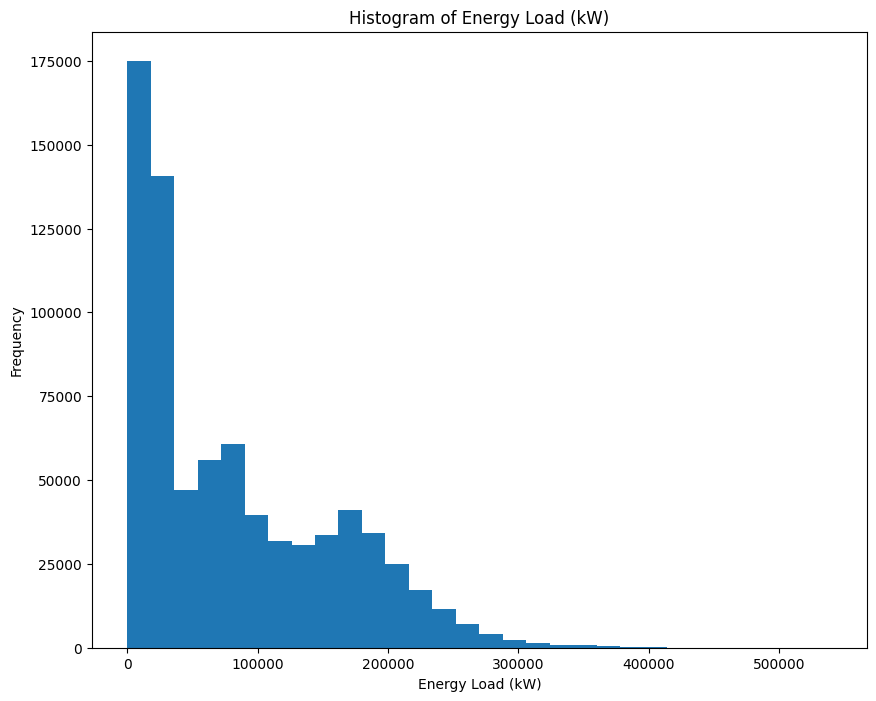

In [7]:
plt.figure(figsize=(10, 8))
plt.hist(load_data['load'], bins=30)
plt.title('Histogram of Energy Load (kW)')
plt.xlabel('Energy Load (kW)')
plt.ylabel('Frequency')
plt.show()

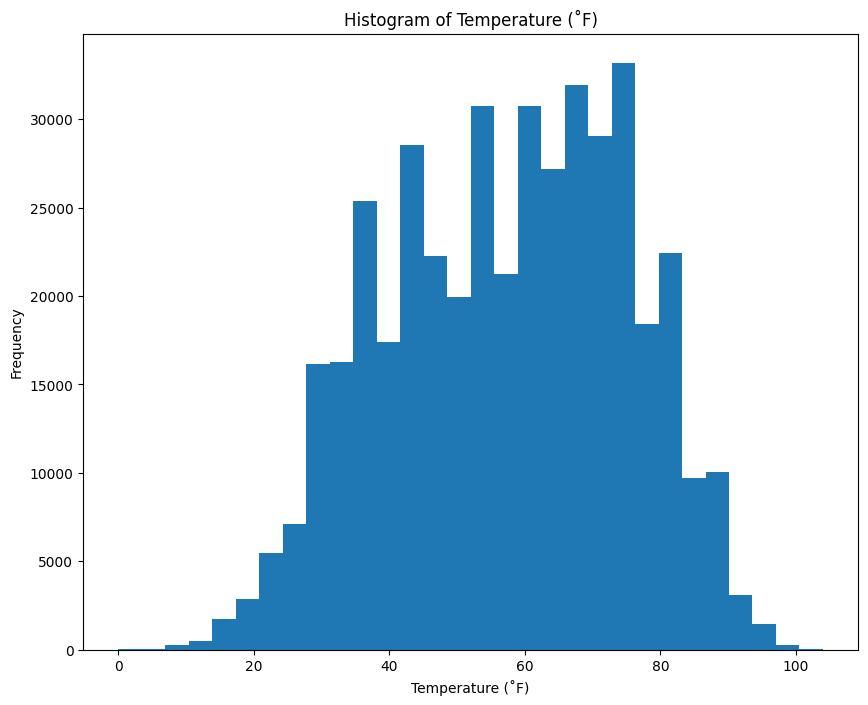

In [8]:
plt.figure(figsize=(10, 8))
plt.hist(temp_data['temp'], bins=30)
plt.title('Histogram of Temperature (˚F)')
plt.xlabel('Temperature (˚F)')
plt.ylabel('Frequency')
plt.show()

## Decomposition
Let's decompose this data to look for seasonal components and the like.

In [94]:
def decompose(data, val_column, periods, plot=False, full=False, raw=False):
    
    data_clean = data.dropna().copy() # cannot have NaNs
    results = {}
    
    for period in periods:

        # step 1: run decomp
        decomp = seasonal_decompose(
            data_clean[val_column],
            model='additive',
            period=period
        )
        results[period] = decomp
        
        # step 2: add data to table
        if full:
            data_clean[f'trend_{period}'] = decomp.trend
        data_clean[f'seasonal_{period}'] = decomp.seasonal
        if full:
            data_clean[f'resid_{period}'] = decomp.resid
        
    # step 3: plot
    if plot:
        def plot_fn(window):
            plt.figure(figsize=(10, 8))
            results[window].plot()
            plt.show()
        interact(plot_fn, window=periods);

    # return
    if raw:
        return data_clean, results
    else:
        return data_clean

def seasonal_rename (data, period_names, full=False):
    drop_cols = []
    for period, name in period_names.items():
        data[f'seasonal_{name}'] = data[f'seasonal_{period}']
        drop_cols.append(f'seasonal_{period}')
        if full:
            data[f'trend_{name}'] = data[f'trend_{period}']
            data[f'resid_{name}'] = data[f'resid_{period}']
            drop_cols.append(f'trend_{period}')
            drop_cols.append(f'resid_{period}')
    return data.drop(columns=drop_cols)

def raw_decomp_rename (decomp, periods_dict):
    result = {}
    for key, val in periods_dict.items():
        result[val] = decomp[key]
    return result

def pretty_decomp(data, val_column, periods_dict, plot=False, full=False):
    p_nums = list(periods_dict.keys())
    decomp = pd.DataFrame()
    if plot:
        decomp, plot = decompose(
            data=data,
            val_column=val_column,
            periods=p_nums,
            plot=False,
            full=full,
            raw=True
        )
        plot = raw_decomp_rename(plot, periods_dict)
        decomp = seasonal_rename(decomp, periods_dict, full)
        p_names = list(periods_dict.values())
        def plot_fn(window):
            plt.figure(figsize=(10, 8))
            plot[window].plot()
            plt.show()
        interact(plot_fn, window=p_names);
        
    else:
        decomp = decompose(
            data=data,
            val_column=val_column,
            periods=p_nums,
            full=full
        )
        decomp = seasonal_rename(decomp, periods_dict, full)
    
    return decomp

In [99]:
load_decomp = pretty_decomp(
    load_data,
    'load',
    {
        24: 'day',
        168: 'week',
        720: 'month',
        8760: 'year'
    },
    plot=True,
    full=False
)

interactive(children=(Dropdown(description='window', options=('day', 'week', 'month', 'year'), value='day'), O…

In [90]:
temp_decomp = pretty_decomp(
    temp_data,
    'temp',
    {
        24: 'day',
        168: 'week',
        720: 'month',
        8760: 'year'
    },
    plot=True,
    full=True
)

interactive(children=(Dropdown(description='window', options=('day', 'week', 'month', 'year'), value='day'), O…

In [102]:
# prep data
y = load_decomp['load']
X = load_decomp.drop(columns=['load', 'datetime'])
X['date_column'] = (load_decomp['datetime'] - load_decomp['datetime'].min()) / np.timedelta64(1, 'D')
X['month'] = load_data['datetime'].dt.month
X['day'] = load_data['datetime'].dt.day
X['weekday'] = load_data['datetime'].dt.weekday
# X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   load   R-squared (uncentered):                   0.503
Model:                            OLS   Adj. R-squared (uncentered):              0.503
Method:                 Least Squares   F-statistic:                          8.553e+04
Date:                Sun, 24 Nov 2024   Prob (F-statistic):                        0.00
Time:                        13:48:09   Log-Likelihood:                     -9.6649e+06
No. Observations:              761400   AIC:                                  1.933e+07
Df Residuals:                  761391   BIC:                                  1.933e+07
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
zone_id         1030.1232     13.890     74.165      0.000    1002.900    1057.346
seasonal_day      -1.7291      0.542     -3.189      0.001      -2.792      -0.666
seasonal_week      1.0036      0.393      2.552      0.011       0.233       1.774
seasonal_month     0.7885      0.195      4.047      0.000       0.407       1.170
seasonal_year      0.9351      0.027     34.258      0.000       0.882       0.989
date_column       25.1338      0.172    146.078      0.000      24.797      25.471
month           2269.6553     23.734     95.631      0.000    2223.138    2316.172
day             1271.8153      9.183    138.492      0.000    1253.816    1289.814
weekday         3668.0947     41.730     87.900      0.000    3586.304    3749.885
==============================================================================
Omnibus:                    71699.316   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            94278.923
Skew:                           0.861   Prob(JB):                         0.00
Kurtosis:                       2.935   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""